<a href="https://colab.research.google.com/github/BenLiu983/Infant-Brand-Prediction/blob/Modeling/Modeling_(feature_combination_1)_1006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
# load the dataset
df1 = pd.read_csv('/content/drive/MyDrive/colab_new_202109/predict_infant_brand/current_infant_brand_clean.csv')
df1

,cur_brand,first_buy_brand,babyage,ZONE,breastfeed,enroll_type2,enroll_age,open_rate0,click_rate0,redem_rate0
0,0,0,120,1,0,1,-247,0.000000,0.000000,0.000000
1,1,1,150,1,1,1,-169,0.052632,0.000000,0.600000
2,0,0,330,1,1,1,-64,0.714286,0.285714,0.000000
3,1,1,60,1,1,0,-31,0.911765,0.205882,0.666667
4,1,1,30,1,0,1,9,0.250000,0.071429,0.250000
...,...,...,...,...,...,...,...,...,...,...
12888,1,0,180,0,1,1,-39,0.289474,0.105263,0.000000
12889,1,1,0,1,1,0,-241,0.782609,0.043478,0.500000
12890,1,0,30,1,1,1,-128,0.271186,0.050847,0.500000
12891,1,1,30,1,1,1,-37,0.210526,0.078947,0.000000


In [4]:
#scale the data
scaler = MinMaxScaler()
print(scaler.fit(df1))
print(scaler.transform(df1))
df2 = pd.DataFrame(scaler.transform(df1))
df2.columns = df1.columns
df2

MinMaxScaler(copy=True, feature_range=(0, 1))
[[0.         0.         0.33333333 ... 0.         0.         0.        ]
 [1.         1.         0.41666667 ... 0.05263158 0.         0.6       ]
 [0.         0.         0.91666667 ... 0.71428571 0.28571429 0.        ]
 ...
 [1.         0.         0.08333333 ... 0.27118644 0.05084746 0.5       ]
 [1.         1.         0.08333333 ... 0.21052632 0.07894737 0.        ]
 [1.         1.         0.25       ... 0.44117647 0.05882353 0.5       ]]


,cur_brand,first_buy_brand,babyage,ZONE,breastfeed,enroll_type2,enroll_age,open_rate0,click_rate0,redem_rate0
0,0.0,0.0,0.333333,1.0,0.0,1.0,0.487926,0.000000,0.000000,0.000000
1,1.0,1.0,0.416667,1.0,1.0,1.0,0.496372,0.052632,0.000000,0.600000
2,0.0,0.0,0.916667,1.0,1.0,1.0,0.507742,0.714286,0.285714,0.000000
3,1.0,1.0,0.166667,1.0,1.0,0.0,0.511316,0.911765,0.205882,0.666667
4,1.0,1.0,0.083333,1.0,0.0,1.0,0.515647,0.250000,0.071429,0.250000
...,...,...,...,...,...,...,...,...,...,...
12888,1.0,0.0,0.500000,0.0,1.0,1.0,0.510449,0.289474,0.105263,0.000000
12889,1.0,1.0,0.000000,1.0,1.0,0.0,0.488576,0.782609,0.043478,0.500000
12890,1.0,0.0,0.083333,1.0,1.0,1.0,0.500812,0.271186,0.050847,0.500000
12891,1.0,1.0,0.083333,1.0,1.0,1.0,0.510666,0.210526,0.078947,0.000000


In [5]:
# train test split
dfx = df2.drop(columns= ['cur_brand'])
X_train, X_test, y_train, y_test = train_test_split(dfx, 
                                                   df2['cur_brand'],
                                                    test_size = 0.2,
                                                    stratify=df2['cur_brand'], 
                                                    random_state=0)

## 1. Model 1 - Logistic Regression

In [6]:
clf_lr = LogisticRegression(max_iter=1000)

# cv
scores = cross_val_score(clf_lr, X_train, y_train, scoring='r2', cv=5)
print(scores)

# make cross validated predictions
y_pred = cross_val_predict(clf_lr, X_train, y_train, cv=5)

print(r2_score(y_train, y_pred))
print("%0.4f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.09830171 0.11388181 0.17620221 0.14698952 0.185594  ]
0.1441903625637967
0.1442 accuracy with a standard deviation of 0.03


In [7]:
clf_lr.fit(X_train, y_train)
# predict 
y_pred_lr = clf_lr.predict(X_test)
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80      1375
         1.0       0.75      0.87      0.81      1204

    accuracy                           0.80      2579
   macro avg       0.81      0.81      0.80      2579
weighted avg       0.81      0.80      0.80      2579



In [8]:
# get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lr)
print(cf_matrix)

[[1018  357]
 [ 151 1053]]


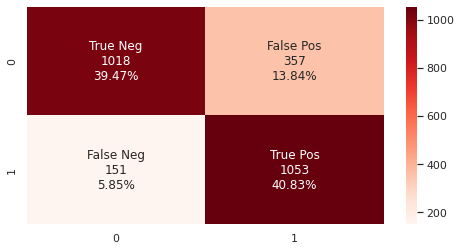

In [9]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

Logistic: ROC AUC=0.837


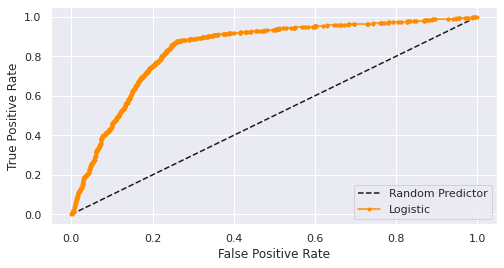

In [10]:
# drawing
lr_probs = clf_lr.predict_proba(X_test)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
 
# calculate scores  Area Under Cruve
lr_auc = roc_auc_score(y_test,lr_probs)
 
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
 
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test,lr_probs)
 
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--',label='Random Predictor')  # draw diag
plt.plot(fpr, tpr, marker='.', color='darkorange',label='Logistic') # draw ROC
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


## Model 1 - Logistic Regression (hyperparameter tuning)

In [11]:
model1 = LogisticRegression()


In [12]:
# Create first pipeline for base without reducing features.
# pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])
# Create param grid.

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf_lr = GridSearchCV(model1, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data

clf_lr.fit(X_train, y_train)
clf_lr.best_params_

Fitting 3 folds for each of 490 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1372 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:  1.4min finished


{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [13]:
print(clf_lr.score(X_test, y_test))

0.8034121752617294


In [14]:
clf_lr = LogisticRegression(C=0.001, max_iter= 100, penalty='l2', solver= 'liblinear')
clf_lr.fit(X_train, y_train)

# Predict 
y_pred_lr = clf_lr.predict(X_test)
# Accuracy
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lr))

accuracy:  0.8034121752617294


[[1019  356]
 [ 151 1053]]


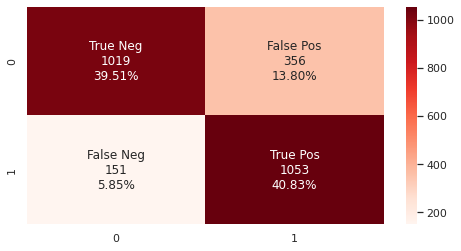

In [15]:
# get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lr)
print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

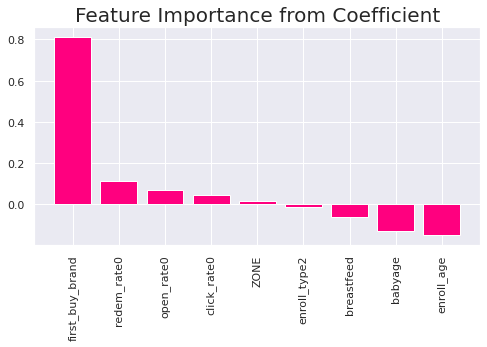

In [16]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': clf_lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#FF007F')
plt.title('Feature Importance from Coefficient', size=20)
sns.set(rc={'figure.figsize':(8,4)})
plt.xticks(rotation='vertical')
plt.show()

## Model 2 - Decision Tree 

In [17]:
clf_dt = tree.DecisionTreeClassifier(max_depth =4)

# cv
scores = cross_val_score(clf_dt, X_train, y_train, scoring='r2', cv=5)
print(scores)

# make cross validated predictions
y_pred = cross_val_predict(clf_dt, X_train, y_train, cv=5)

print(r2_score(y_train, y_pred))
print("%0.4f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


[0.09440668 0.11777683 0.17620221 0.15283206 0.18364566]
0.1449694336948265
0.1450 accuracy with a standard deviation of 0.03


In [18]:
clf_dt.fit(X_train, y_train)
# Predict 
y_pred_dt = clf_dt.predict(X_test)
# Accuracy
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt))

accuracy:  0.8030244280728964


In [19]:
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80      1375
         1.0       0.74      0.88      0.81      1204

    accuracy                           0.80      2579
   macro avg       0.81      0.81      0.80      2579
weighted avg       0.81      0.80      0.80      2579



In [20]:
# get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_dt)
print(cf_matrix)

[[1011  364]
 [ 144 1060]]


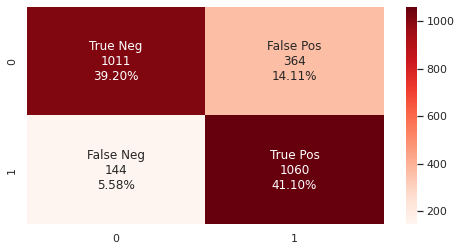

In [21]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

## Model 2 - Decision Tree (Hyperparameter Tuning)

In [22]:
model2 = DecisionTreeClassifier()

In [23]:
parameters = {'splitter' : ['best', 'random'],
'criterion' : ['gini', 'entropy'],
'max_depth': [2, 4, 6, 8, 10],
'min_samples_split': [2, 4, 6, 8, 10],
}

In [24]:
grid_search_dt = GridSearchCV(estimator = model2,
param_grid = parameters,
scoring = 'accuracy',
cv = 3,
verbose = 1)

In [25]:
grid_search_dt.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [26]:
print(grid_search_dt.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')


In [27]:
print(grid_search_dt.score(X_test, y_test))

0.8030244280728964


In [28]:
clf_dt = grid_search_dt.best_estimator_

clf_dt.fit(X_train, y_train)
# Predict 
y_pred_dt = clf_dt.predict(X_test)
# Accuracy
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt))

accuracy:  0.8034121752617294


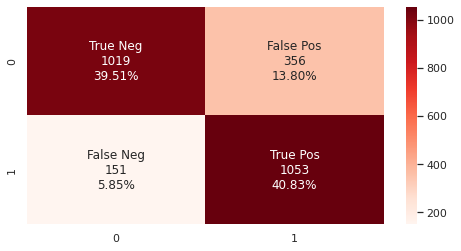

In [29]:
cf_matrix = confusion_matrix(y_test, y_pred_dt)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

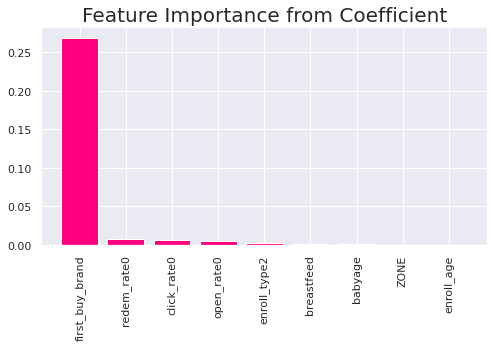

In [30]:
# feature importance
feat_importance = clf_dt.tree_.compute_feature_importances(normalize=False)
feat_importance

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': feat_importance
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#FF007F')
plt.title('Feature Importance from Coefficient', size=20)
plt.xticks(rotation='vertical')
sns.set(rc={'figure.figsize':(12,4)})
plt.show()

## Model 3 - LightGBM

In [31]:
lgb_clf = LGBMClassifier(n_estimators = 1000, 
                         learning_rate = 0.01)

# cv
scores = cross_val_score(lgb_clf, X_train, y_train, scoring='r2', cv=5)
print(scores)

# make cross validated predictions
y_pred = cross_val_predict(lgb_clf, X_train, y_train, cv=5)

print(r2_score(y_train, y_pred))
print("%0.4f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


[0.09245917 0.06324648 0.18204475 0.1430945  0.15442057]
0.1270507976811418
0.1271 accuracy with a standard deviation of 0.04


In [32]:
lgb_clf.fit(X_train, y_train)

# Predict 
y_pred_lgb = lgb_clf.predict(X_test)

# Accuracy
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lgb))

accuracy:  0.7952694842962389


In [33]:
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_lgb))

              precision    recall  f1-score   support

         0.0       0.86      0.74      0.79      1375
         1.0       0.74      0.86      0.80      1204

    accuracy                           0.80      2579
   macro avg       0.80      0.80      0.80      2579
weighted avg       0.80      0.80      0.80      2579



In [34]:
# get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lgb)
print(cf_matrix)

[[1016  359]
 [ 169 1035]]


<Figure size 864x288 with 0 Axes>

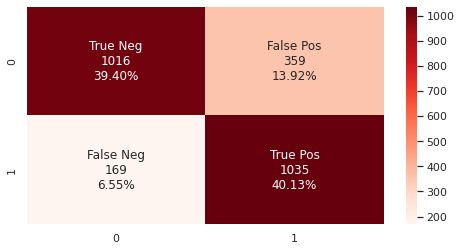

In [35]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure()
plt.figure(figsize=(8,4))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

## Model 3 - LightGBM (hyperparameter tuning)

In [36]:
# Grid search
lgb_clf = LGBMClassifier()

lgb_param_grid = {'learning_rate': np.arange(0.01, 0.10, 0.01),
                  'n_estimators': np.arange(200, 1000, 200),
                  'max_depth': [4,6,8,10]
                  }

random_lgb = RandomizedSearchCV(estimator=lgb_clf, 
                                    param_distributions=lgb_param_grid,
                                    n_iter=100, 
                                    scoring='accuracy', 
                                    cv=3, 
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_lgb.fit(X_train, y_train)
print("Best parameters found: ",random_lgb.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


Best parameters found:  {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.01}


In [37]:
# Use the best parameter to caculate roc_auc
lgb_clf = LGBMClassifier(n_estimators = 400,  max_depth=4,learning_rate = 0.01)
lgb_clf.fit(X_train, y_train)

# Predict 
y_pred_lgb = lgb_clf.predict(X_test)

# Plot roc
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_lgb))

              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80      1375
         1.0       0.74      0.88      0.81      1204

    accuracy                           0.80      2579
   macro avg       0.81      0.81      0.80      2579
weighted avg       0.81      0.80      0.80      2579



<Figure size 864x288 with 0 Axes>

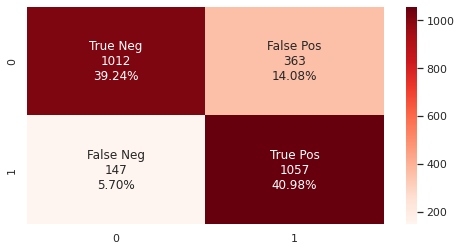

In [38]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lgb)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure()
plt.figure(figsize=(8,4))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

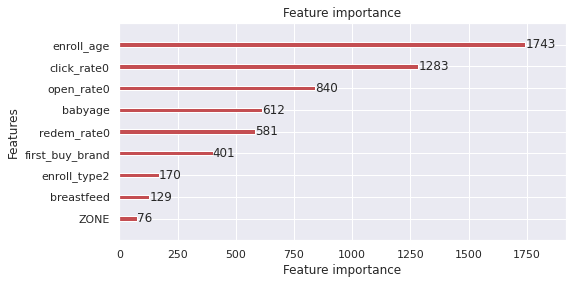

In [39]:
sns.set(rc={'figure.figsize':(8,4)})
plot_importance(lgb_clf, color='r')

## Model 4 - ANN

In [40]:
# set the model
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Dense(units=50, activation='relu', input_shape=(9, )))
# model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [41]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [42]:
model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [43]:
X_train = np.array(X_train).reshape(-1,9)
X_train.shape

(10314, 9)

In [44]:
# train the model
epochs_hist = model1.fit(X_train, y_train, epochs = 100, batch_size=50)

Epoch 1/100
207/207 [==============================] - 1s 1ms/step - loss: 0.5798 - accuracy: 0.7565
Epoch 2/100
207/207 [==============================] - 0s 1ms/step - loss: 0.5015 - accuracy: 0.7874
Epoch 3/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4956 - accuracy: 0.7874
Epoch 4/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.7874
Epoch 5/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4930 - accuracy: 0.7875
Epoch 6/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4922 - accuracy: 0.7874
Epoch 7/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4921 - accuracy: 0.7869
Epoch 8/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4910 - accuracy: 0.7870
Epoch 9/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4918 - accuracy: 0.7869
Epoch 10/100
207/207 [==============================] - 0s 1ms/step - loss: 0.4909 - accura

In [45]:
# Predict 
y_pred_ann = model1.predict(X_test)
y_pred_ann

array([[0.7936418 ],
       [0.4550386 ],
       [0.689416  ],
       ...,
       [0.836639  ],
       [0.07500309],
       [0.09670335]], dtype=float32)

In [46]:
y_test

5728     1.0
10553    1.0
2700     1.0
3952     0.0
1201     0.0
        ... 
11713    1.0
277      1.0
8739     1.0
10071    0.0
453      0.0
Name: cur_brand, Length: 2579, dtype: float64

In [47]:
y_pred_ann = (y_pred_ann > df1['cur_brand'].mean())

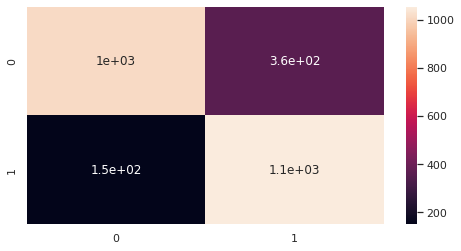

In [48]:
# visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm, annot=True)

<Figure size 576x288 with 0 Axes>

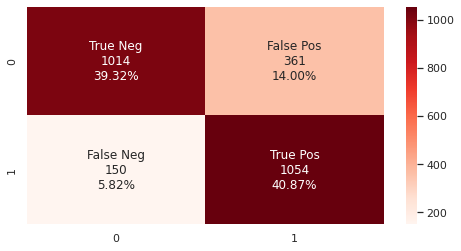

In [49]:
cf_matrix = confusion_matrix(y_test, y_pred_ann)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure()
plt.figure(figsize=(8,4))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')